In [99]:
import numpy as np
from astropy.io import fits
import urllib.request
import matplotlib.pyplot as pl
from astropy import stats
%matplotlib inline

In [2]:
# get fits files
# but like don't run this more than once it takes fucking forever.

url = 'http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/'

labels = ['HLC.RA_20_to_21.fits.gz',
'HLC.RA_21_to_22.fits.gz',
'HLC.RA_22_to_23.fits.gz',
'HLC.RA_23_to_24.fits.gz',
'HLC.RA_00_to_01.fits.gz',
'HLC.RA_01_to_02.fits.gz',
'HLC.RA_02_to_03.fits.gz',
'HLC.RA_03_to_04.fits.gz']

fits_files = []
for l in labels:
    location = './' + l[:-3]
    print('downloading file: ' + l)
    #urllib.request.urlretrieve(url + l, location)
    print('finished: ' + l)
    fits_files.append(location)

downloading file: HLC.RA_20_to_21.fits.gz
finished: HLC.RA_20_to_21.fits.gz
downloading file: HLC.RA_21_to_22.fits.gz
finished: HLC.RA_21_to_22.fits.gz
downloading file: HLC.RA_22_to_23.fits.gz
finished: HLC.RA_22_to_23.fits.gz
downloading file: HLC.RA_23_to_24.fits.gz
finished: HLC.RA_23_to_24.fits.gz
downloading file: HLC.RA_00_to_01.fits.gz
finished: HLC.RA_00_to_01.fits.gz
downloading file: HLC.RA_01_to_02.fits.gz
finished: HLC.RA_01_to_02.fits.gz
downloading file: HLC.RA_02_to_03.fits.gz
finished: HLC.RA_02_to_03.fits.gz
downloading file: HLC.RA_03_to_04.fits.gz
finished: HLC.RA_03_to_04.fits.gz


In [189]:
# process data for stars 

from astroML.stats import binned_statistic_2d

counts = []
ra_means = []
dec_means = []
ra_pm_means = []
dec_pm_means = []
red_means = []
for f in fits_files:
    data = fits.open(f)
    stars = [d for d in data[1].data if d['MEAN_OBJECT_TYPE'] > 5]
    u = np.array([s['MEAN_EXPMAG'][0] for s in stars])
    g = np.array([s['MEAN_EXPMAG'][1] for s in stars])
    r = np.array([s['MEAN_EXPMAG'][2] for s in stars])
    i = np.array([s['MEAN_EXPMAG'][3] for s in stars])
    z = np.array([s['MEAN_EXPMAG'][4] for s in stars])
    ra = np.array([s['RA_MEAN'] for s in stars])
    dec = np.array([s['DEC_MEAN'] for s in stars])
    ra_pm = np.array([s['RA_PM'] for s in stars])
    dec_pm = np.array([s['DEC_PM'] for s in stars])
    reddening = np.array([s['REDDENING'][0] for s in stars])
    flag = (r != 0) & (i != 0) & (g != 0)
    count = binned_statistic_2d(r[flag], g[flag]-i[flag], r, 'count', bins=200)
    ra_means.append(binned_statistic_2d(r[flag], g[flag] - i[flag], ra[flag], 'median', bins=200))
    dec_means.append(binned_statistic_2d(r[flag], g[flag] - i[flag], dec[flag], 'median', bins=200))
    ra_pm_means.append(binned_statistic_2d(r[flag], g[flag] - i[flag], dec_pm[flag], 'median', bins=200))
    dec_pm_means.append(binned_statistic_2d(r[flag], g[flag] - i[flag], ra_pm[flag], 'median', bins=200))
    red_means.append(binned_statistic_2d(r[flag], g[flag]-i[flag], reddening[flag], 'median', bins=200))
    counts.append(count)

/usr/local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/usr/local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


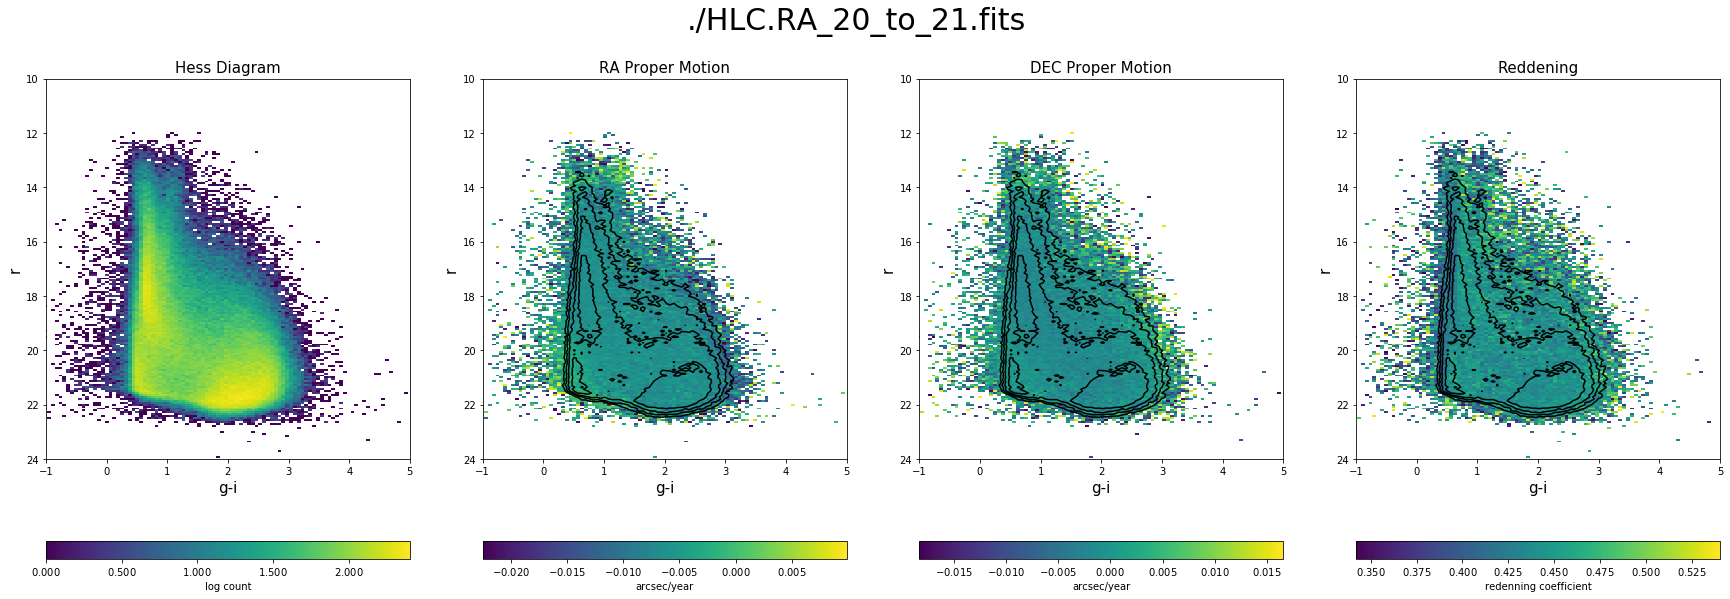

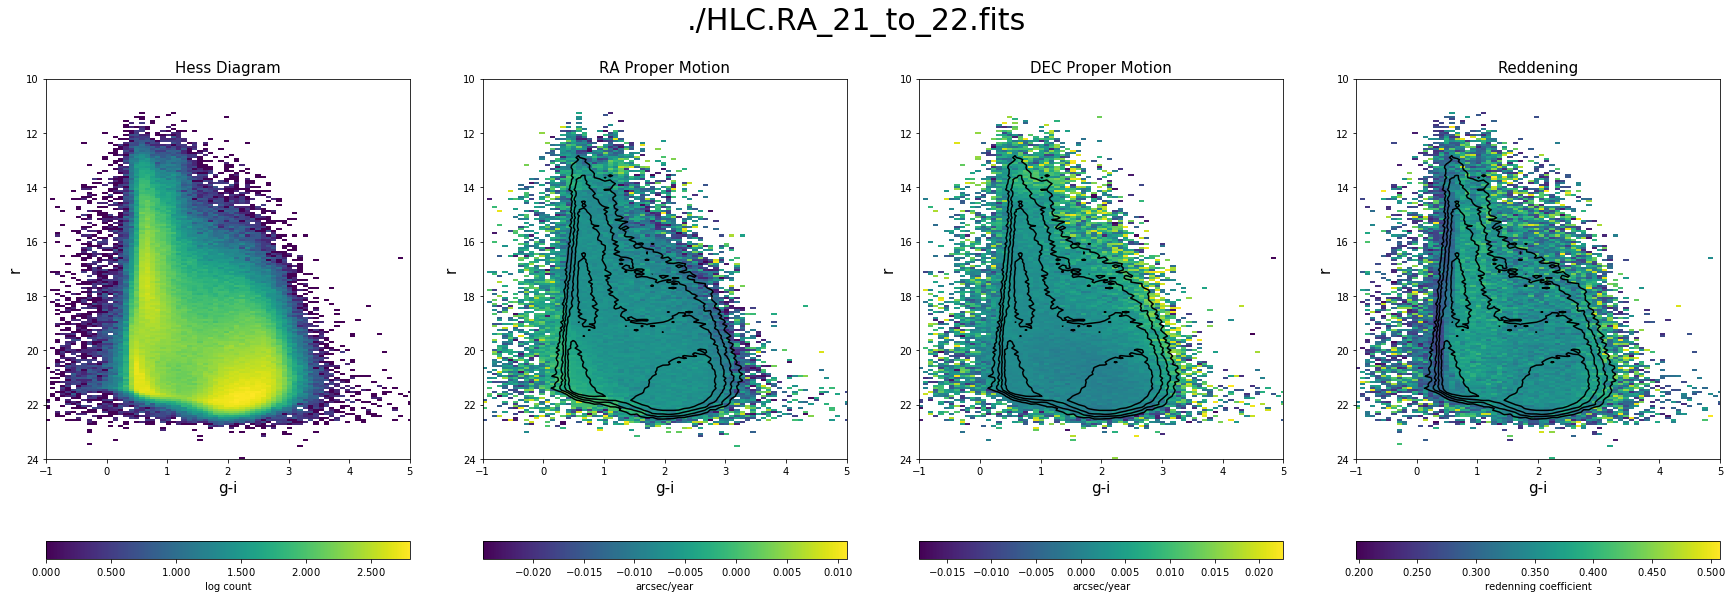

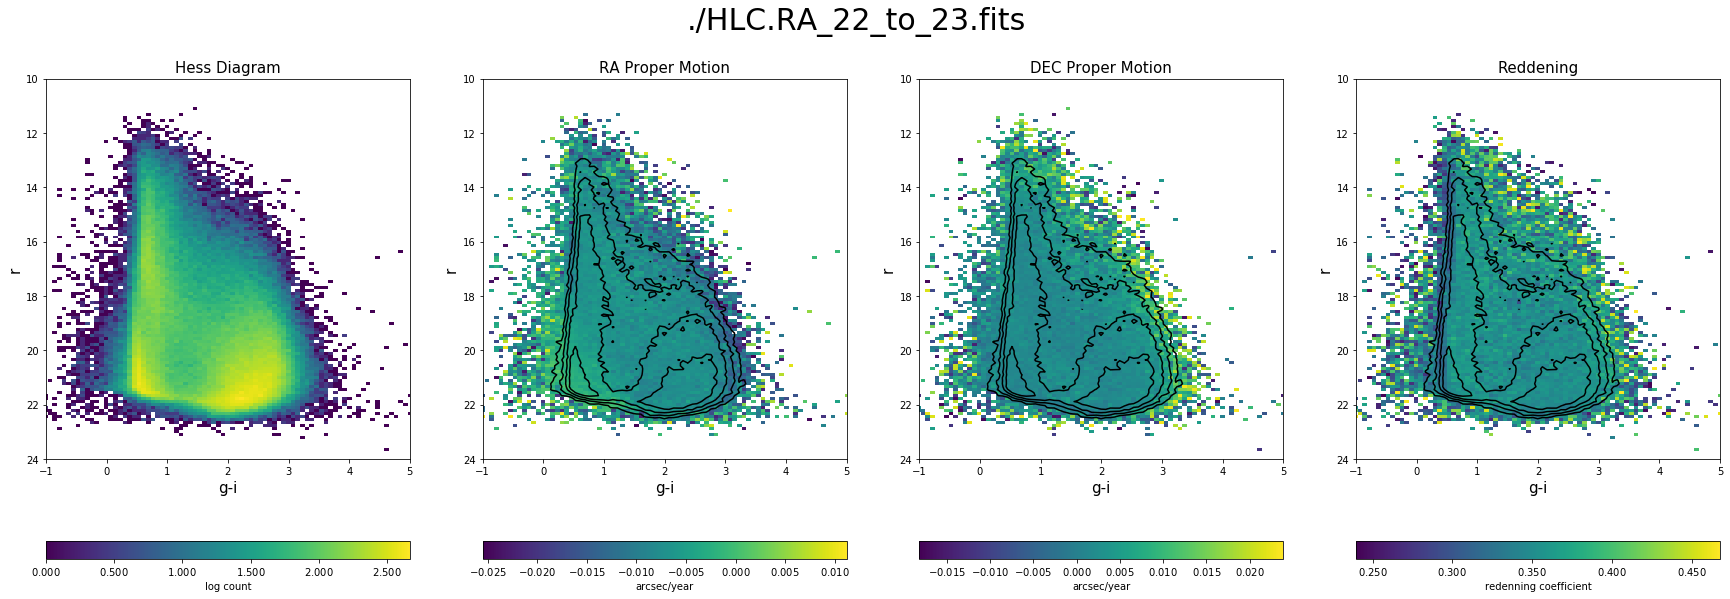

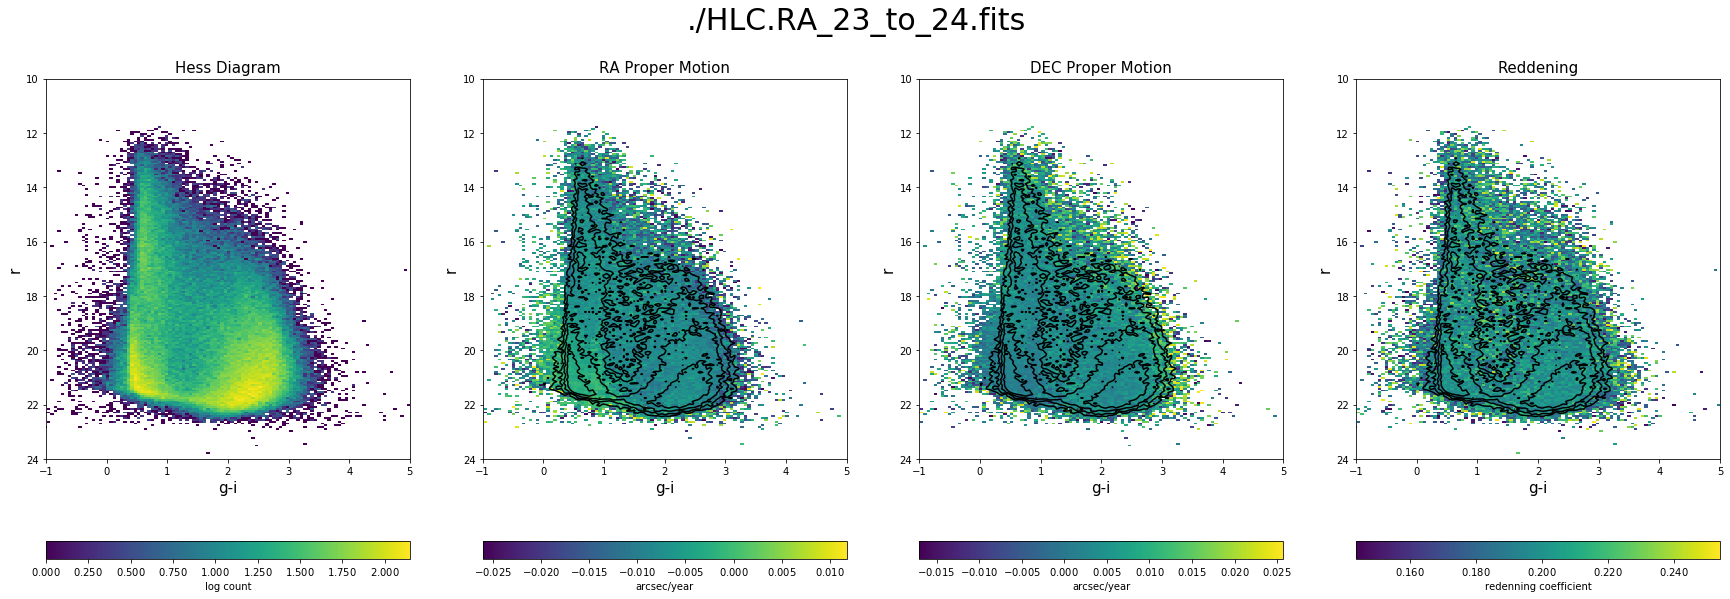

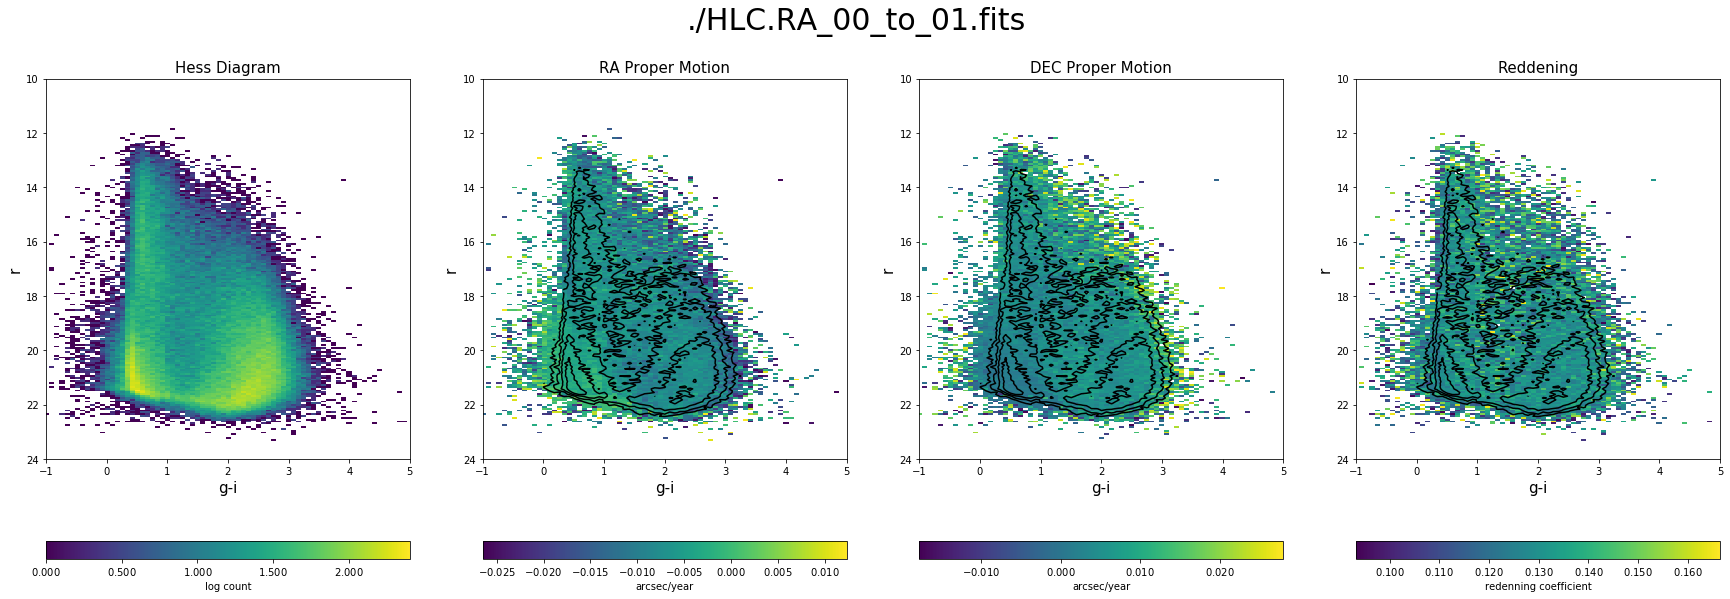

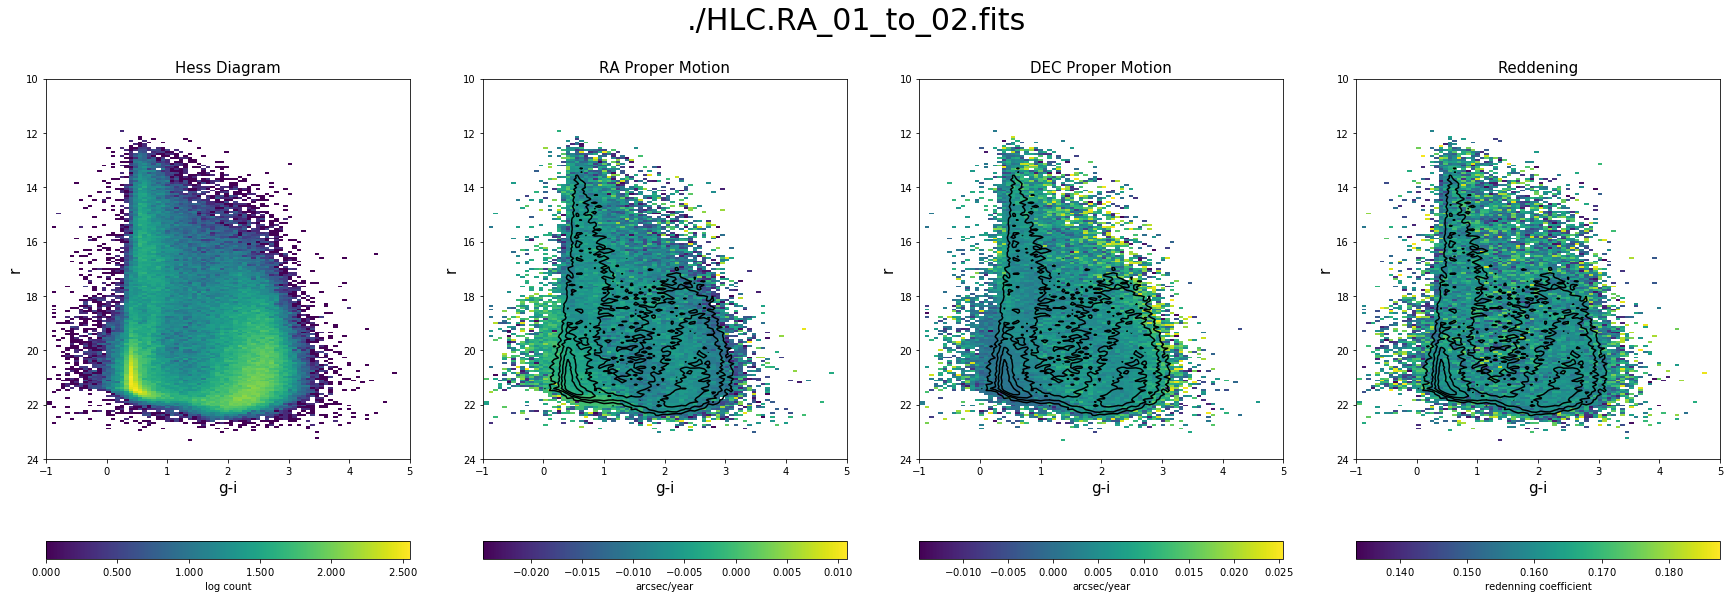

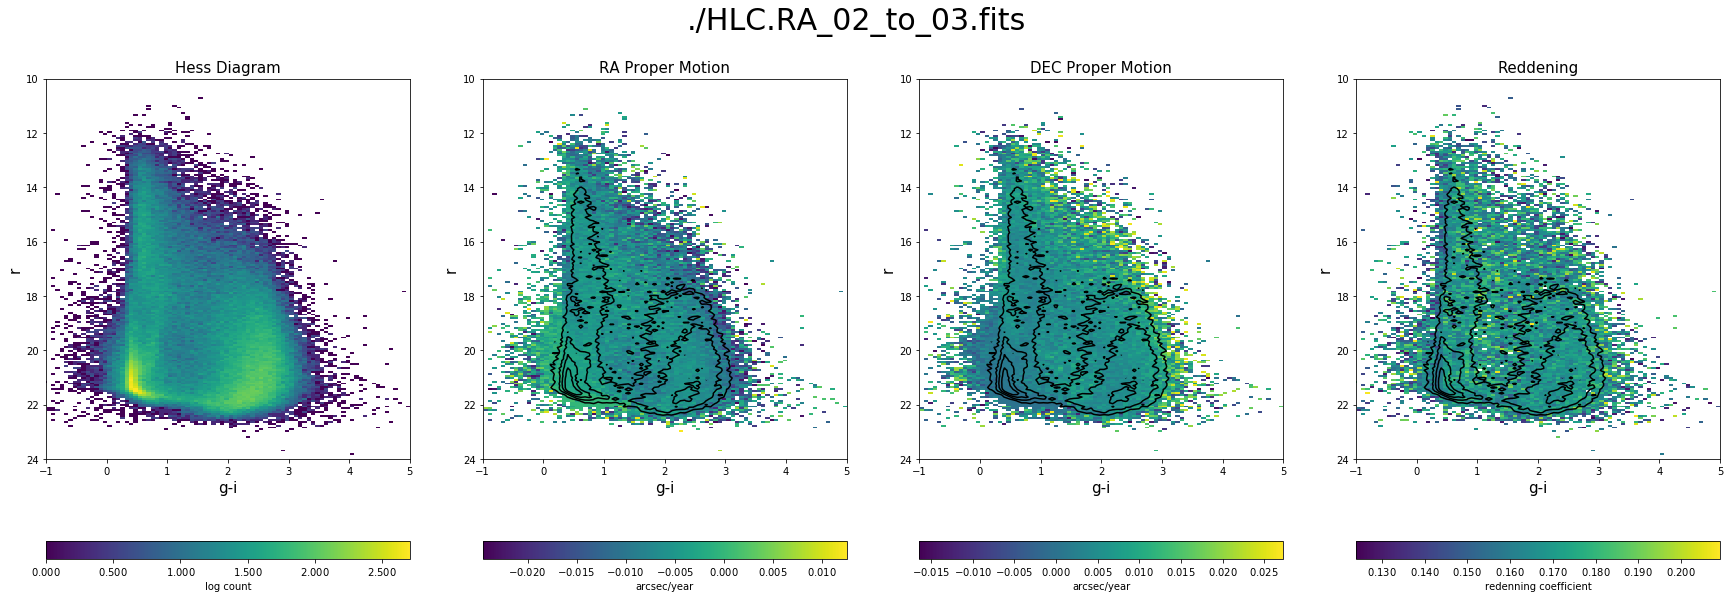

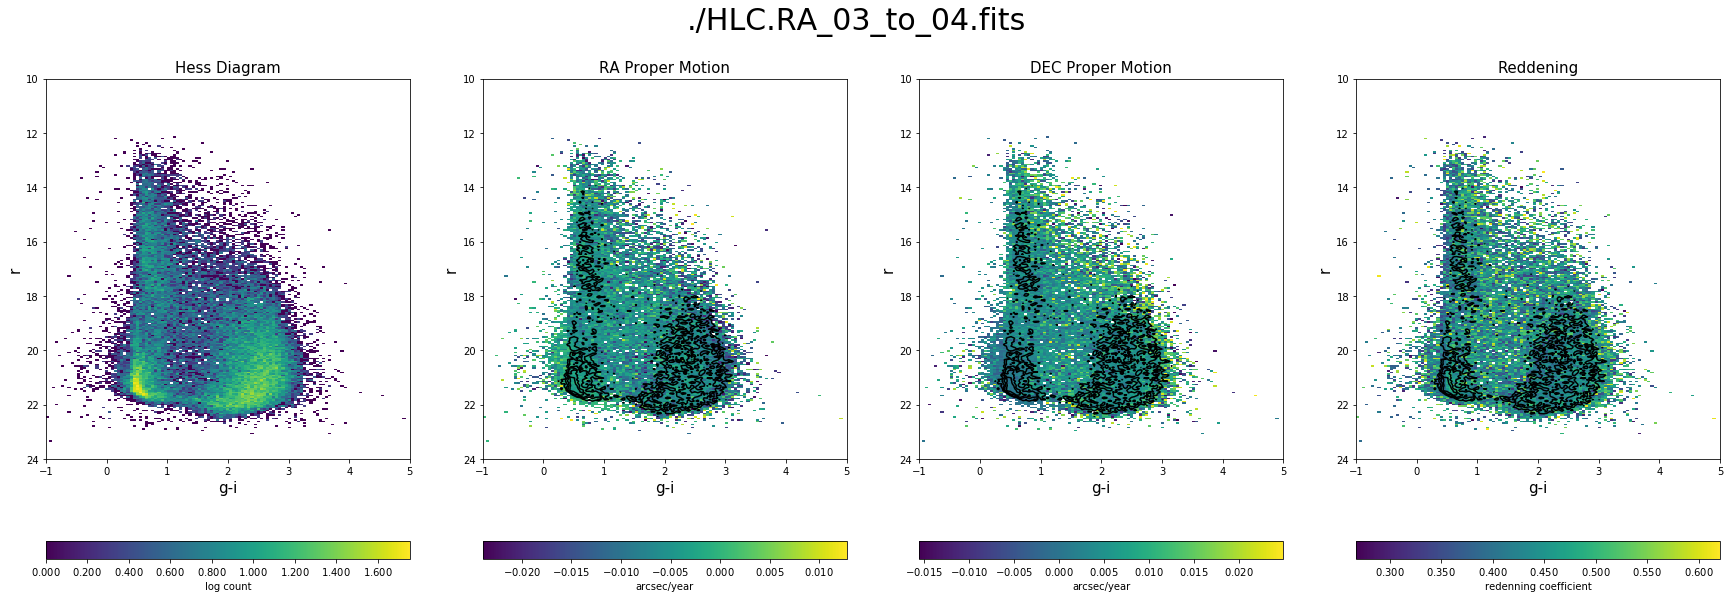

In [190]:
# plotting for stars

def plot_contour(N, x_edge, y_edge, values, cbtitle):
    cmap = pl.cm.viridis
    cmap.set_bad('w', 1)
    
    pl.imshow(values, origin='upper',
               extent=[y_edge[0], y_edge[-1], x_edge[-1], x_edge[0]],
               aspect='auto', interpolation='nearest', cmap=cmap)
    cb = pl.colorbar(format=r'$%.3f$', orientation='horizontal')
    cb.set_label(cbtitle)
    max_counts = np.log10(np.max(N))
    levels = np.linspace(max_counts/2, max_counts, 5)
    pl.contour(np.log10(N), levels, colors='k', origin='upper',
               extent=[y_edge[0], y_edge[-1], x_edge[-1], x_edge[0]])
    pl.xlim(-1, 5)
    pl.ylim(24, 10)
    pl.xlabel('g-i')
    pl.ylabel('r')
    return fig

# plot r vs g-i hess diagram
def plot_hess(N, x_edge, y_edge, cbtitle):
    cmap = pl.cm.viridis
    cmap.set_bad('w', 1)
    pl.imshow(np.log10(N), origin='upper',
               extent=[y_edge[0], y_edge[-1], x_edge[-1], x_edge[0]],
               aspect='auto', interpolation='nearest', cmap=cmap)
    cb = pl.colorbar(format=r'$%.3f$', orientation='horizontal')
    cb.set_label(cbtitle)
    pl.xlim(-1, 5)
    pl.ylim(24, 10)
    pl.xlabel('g-i')
    pl.ylabel('r')
    return fig
fig = pl.figure(figsize=(20, 20))

# make plots
for i, c, ra, dec, ra_pm, dec_pm, red in zip(np.arange(len(counts)), counts, ra_means, dec_means, ra_pm_means, dec_pm_means, red_means):
    
    fig = pl.figure(figsize=(30, 10))
    pl.suptitle(fits_files[i], size=30)
    N = c[0]
    x = c[1]
    y = c[2]
    ra = ra[0]
    dec = dec[0]
    ra_pm = ra_pm[0]
    dec_pm = dec_pm[0]
    red = red[0]
    pm = np.sqrt(ra_pm**2 + dec_pm**2)
    ra = stats.sigma_clip(ra, sigma=5)
    dec = stats.sigma_clip(dec, sigma=5)
    pm = stats.sigma_clip(pm, sigma=5)
    ra_pm = stats.sigma_clip(ra_pm, sigma=3)
    dec_pm = stats.sigma_clip(dec_pm, sigma=3)
    red = stats.sigma_clip(red, sigma=3)
    
    # hess diagram 
    pl.subplot(141)
    plot_hess(N, x, y, 'log count');
    pl.title('Hess Diagram', size=15)
    pl.xlabel('g-i', size=15)
    pl.ylabel('r', size=15)
    
    # right ascension proper motion
    pl.subplot(142)
    plot_contour(N, x, y, ra_pm, 'arcsec/year');
    pl.title('RA Proper Motion', size=15)
    pl.xlabel('g-i', size=15)
    pl.ylabel('r', size=15)
    
    # declination proper motion 
    pl.subplot(143)
    plot_contour(N, x, y, dec_pm, 'arcsec/year');
    pl.title('DEC Proper Motion', size=15)
    pl.xlabel('g-i', size=15)
    pl.ylabel('r', size=15)
    
    # redenning
    pl.subplot(144)
    plot_contour(N, x, y, red, 'redenning coefficient')
    pl.title('Reddening', size=15)
    pl.xlabel('g-i', size=15)
    pl.ylabel('r', size=15)

In [191]:
# process data for galaxies

counts = []
ra_means = []
dec_means = []
ra_pm_means = []
dec_pm_means = []
red_means = []
for f in fits_files:
    data = fits.open(f)
    galaxies = [d for d in data[1].data if d['MEAN_OBJECT_TYPE'] < 5]
    u = np.array([g['MEAN_EXPMAG'][0] for g in galaxies])
    g = np.array([g['MEAN_EXPMAG'][1] for g in galaxies])
    r = np.array([g['MEAN_EXPMAG'][2] for g in galaxies])
    i = np.array([g['MEAN_EXPMAG'][3] for g in galaxies])
    z = np.array([g['MEAN_EXPMAG'][4] for g in galaxies])
    reddening = np.array([g['REDDENING'][0] for g in galaxies])
    ra = np.array([g['RA_MEAN'] for g in galaxies])
    dec = np.array([g['DEC_MEAN'] for g in galaxies])
    ra_pm = np.array([g['RA_PM'] for g in galaxies])
    dec_pm = np.array([g['DEC_PM'] for g in galaxies])
    flag = (r != 0) & (i != 0) & (g != 0)
    count = binned_statistic_2d(r[flag], g[flag]-i[flag], r, 'count', bins=200)
    ra_means.append( binned_statistic_2d(r[flag], g[flag] - i[flag], ra[flag], 'mean', bins=200))
    dec_means.append(binned_statistic_2d(r[flag], g[flag] - i[flag], dec[flag], 'mean', bins=200))
    ra_pm_means.append(binned_statistic_2d(r[flag], g[flag] - i[flag], dec_pm[flag], 'mean', bins=200))
    dec_pm_means.append(binned_statistic_2d(r[flag], g[flag] - i[flag], ra_pm[flag], 'mean', bins=200))
    red_means.append(binned_statistic_2d(r[flag], g[flag]-i[flag], reddening[flag], 'median', bins=200))
    counts.append(count)

/usr/local/lib/python3.6/site-packages/astroML/stats/_binned_statistic.py:323: RuntimeWarning: invalid value encountered in true_divide
  result[a] /= flatcount


/usr/local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:158: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
/usr/local/lib/python3.6/site-packages/astropy/stats/sigma_clipping.py:159: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


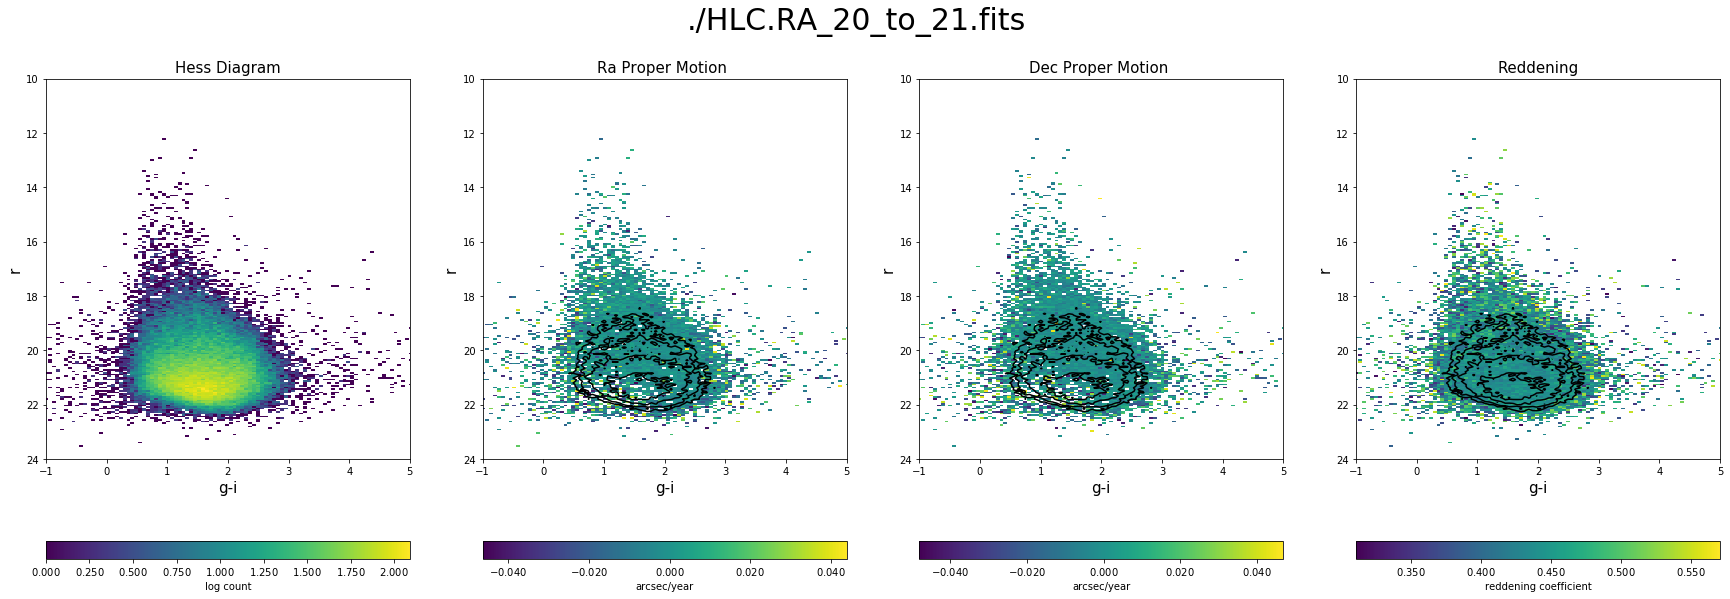

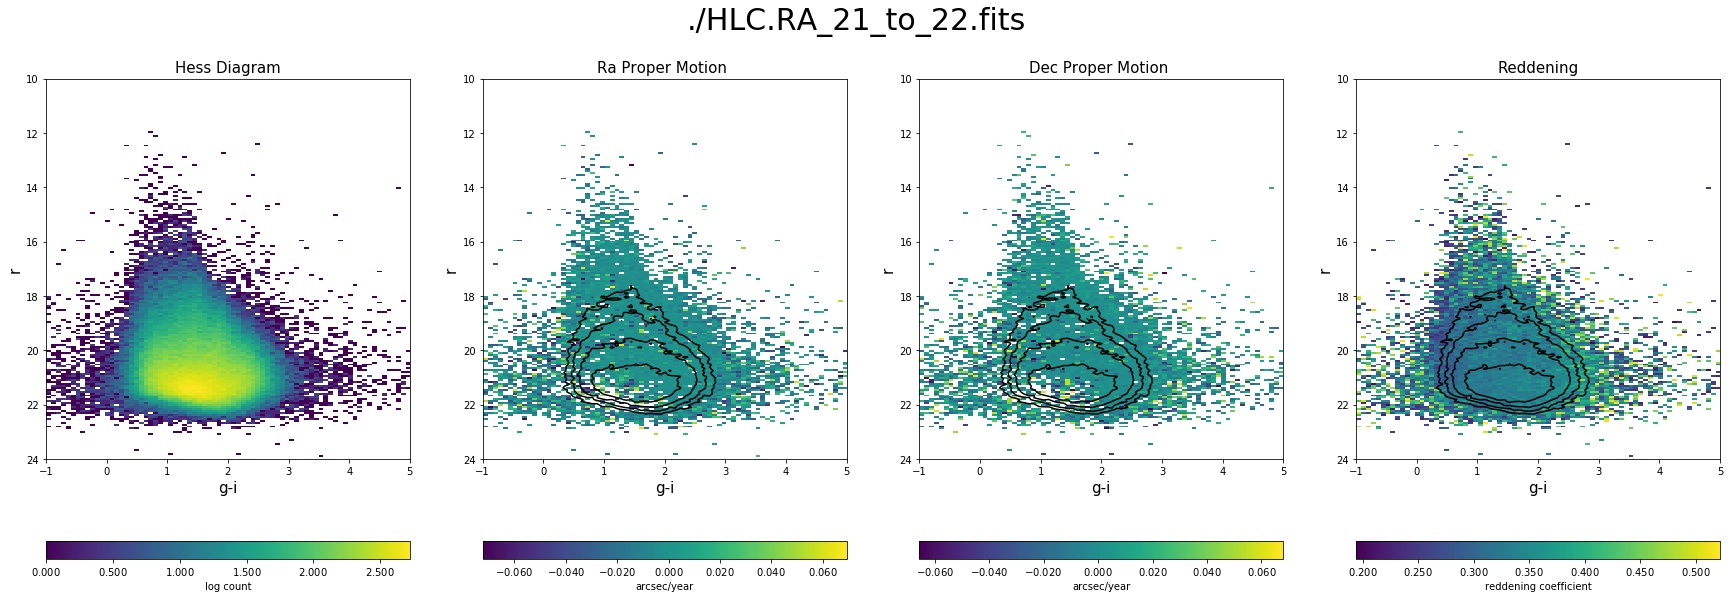

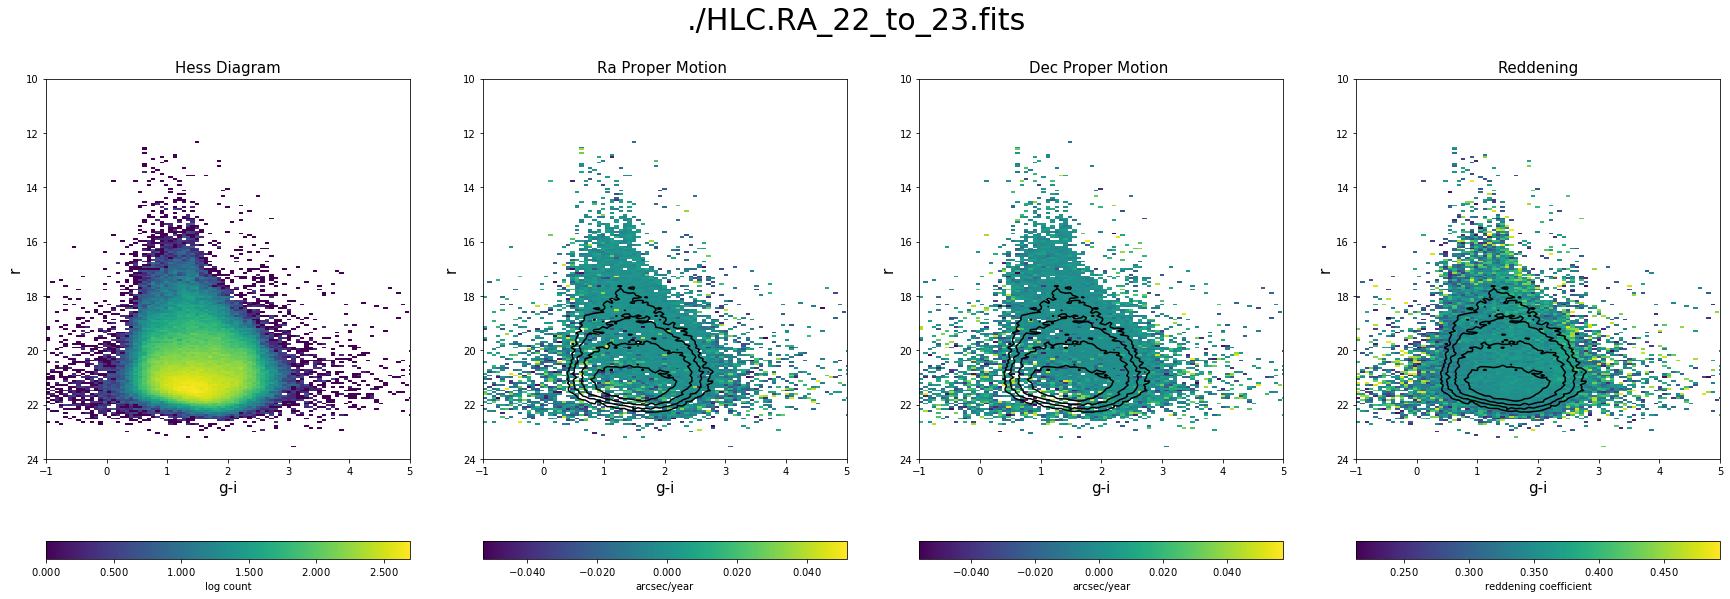

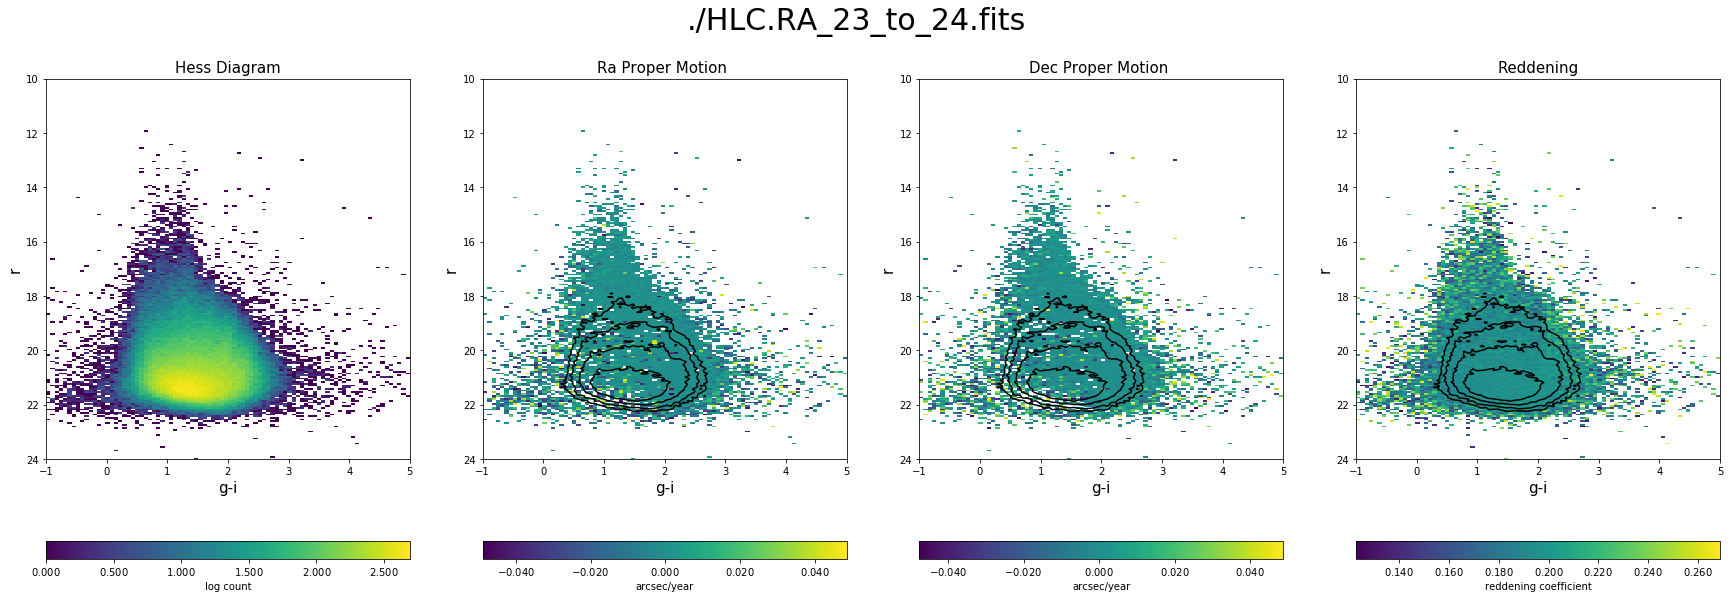

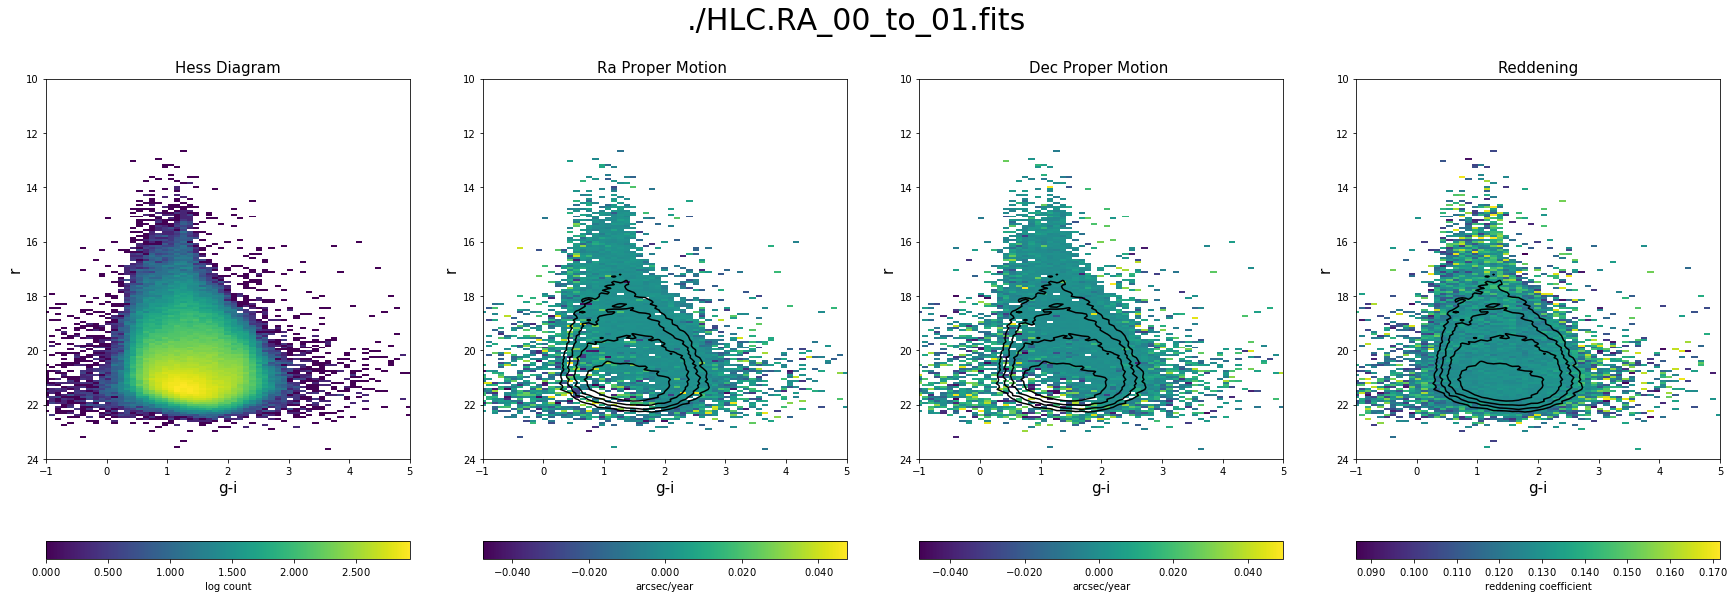

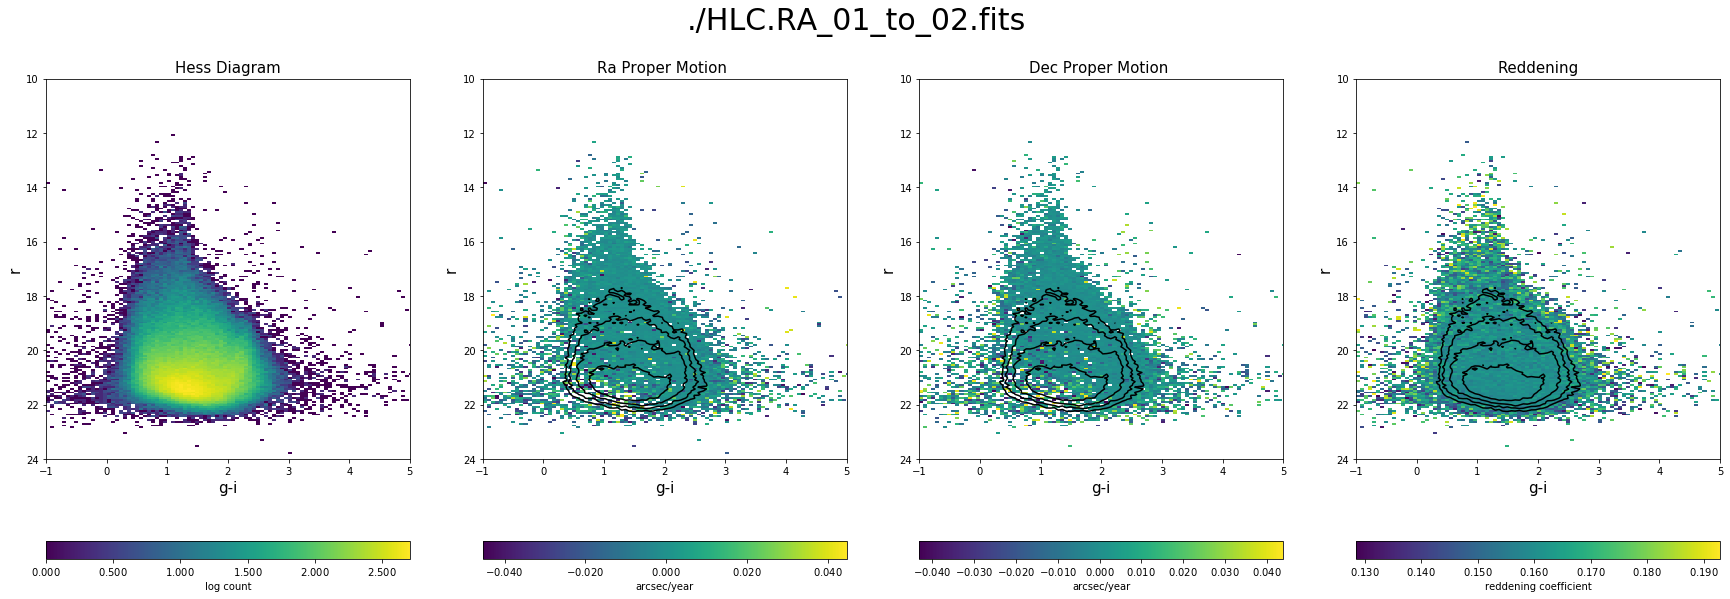

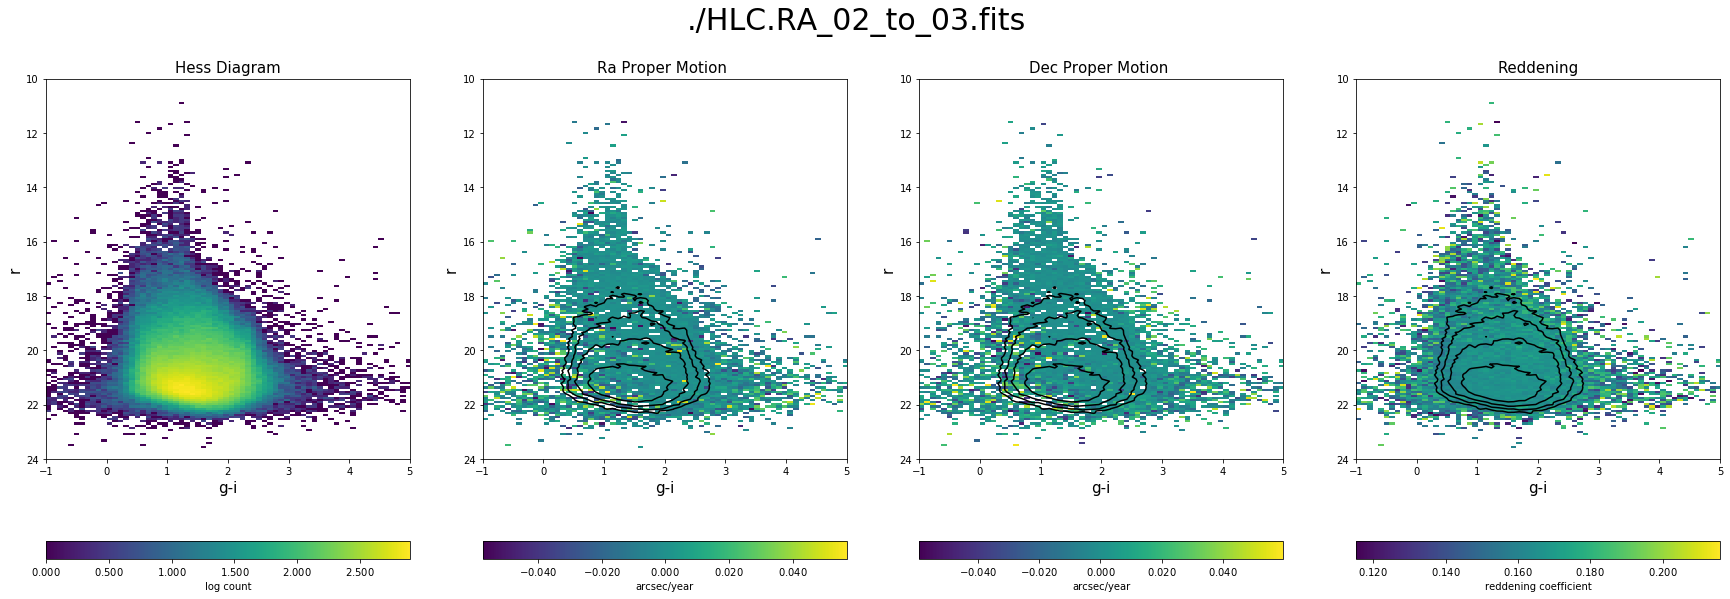

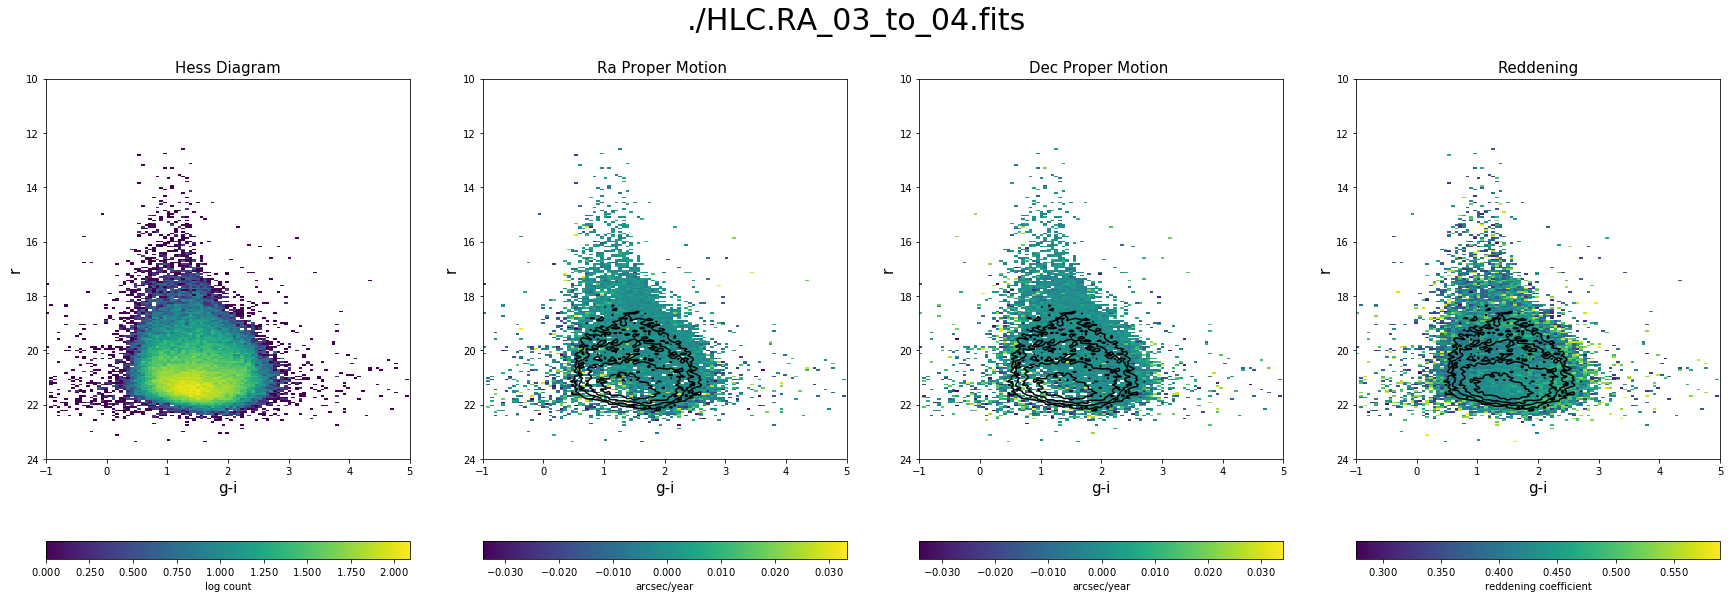

In [192]:
# plotting galaxies

fig = pl.figure(figsize=(20, 20))

for i, c, ra, dec, ra_pm, dec_pm, red in zip(np.arange(len(counts)), counts, ra_means, dec_means, ra_pm_means, dec_pm_means, red_means):
    fig = pl.figure(figsize=(30, 10))
    pl.suptitle(fits_files[i], size=30)
    pl.subplot(141)
    N = c[0]
    x = c[1]
    y = c[2]
    ra_pm = ra_pm[0]
    dec_pm = dec_pm[0]
    red = red[0]
    pm = np.sqrt(ra_pm**2 + dec_pm**2)
    ra = ra[0]
    dec = dec[0]
    ra_pm = stats.sigma_clip(ra_pm, sigma=3)
    dec_pm = stats.sigma_clip(dec_pm, sigma=3)
    pm = stats.sigma_clip(pm, sigma=3)
    red = stats.sigma_clip(red, sigma=3)
    
    # Hess diagram
    plot_hess(N, x, y, 'log count');
    pl.title('Hess Diagram', size=15)
    pl.xlabel('g-i', size=15)
    pl.ylabel('r', size=15)
    
    # Ra proper motion 
    pl.subplot(142)
    plot_contour(N, x, y, ra_pm, 'arcsec/year');
    pl.title('Ra Proper Motion ', size=15)
    pl.xlabel('g-i', size=15)
    pl.ylabel('r', size=15)
    
    # Dec proper motion 
    pl.subplot(143)
    plot_contour(N, x, y, dec_pm, 'arcsec/year');
    pl.title('Dec Proper Motion ', size=15)
    pl.xlabel('g-i', size=15)
    pl.ylabel('r', size=15)
        
    # redenning
    pl.subplot(144)
    plot_contour(N, x, y, red, 'reddening coefficient')
    pl.title('Reddening', size=15)
    pl.xlabel('g-i', size=15)
    pl.ylabel('r', size=15)